### Agenda:
1. Data Loading & Preprocessing
   - Pivoting
   - Missing values handling
   - Date features creation
   - Train/Test split
   - Scaling
   - Sequences
   - Data Loader (incl. indexing)
2. Chronos Model
3. BasisFormer
4. Non-Stationary Transformer
5. iTransformer
6. Synthtic Data Generation
   - Chronos Simulation Framework
   - DYNOTEARS Causal Structure
   - Augmentation


In [1]:
#!pip install torch==2.0.1

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.utils.weight_norm as wn
import torch.nn.functional as F
import argparse
import os
import logging
from torch.utils.tensorboard import SummaryWriter
import time
from chronos import ChronosPipeline

# Data Preprocessing

In [3]:
##file_path = '/content/all_countries.csv' ## colab path
file_path = 'data/all_countries.csv' ## jupyter path
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
df.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Austria,AUT,2015-01-01 00:00:00,2015-01-01 01:00:00,17.93
1,Austria,AUT,2015-01-01 01:00:00,2015-01-01 02:00:00,15.17
2,Austria,AUT,2015-01-01 02:00:00,2015-01-01 03:00:00,16.38
3,Austria,AUT,2015-01-01 03:00:00,2015-01-01 04:00:00,17.38
4,Austria,AUT,2015-01-01 04:00:00,2015-01-01 05:00:00,16.38


In [4]:
df = df [['Country','Datetime (UTC)',  'Price (EUR/MWhe)']]
df = df.pivot(index='Datetime (UTC)', columns='Country', values='Price (EUR/MWhe)')
df.head()

Country,Austria,Belgium,Bulgaria,Croatia,Czechia,Denmark,Estonia,Finland,France,Germany,...,Norway,Poland,Portugal,Romania,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland
Datetime (UTC),,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,17.93,34.94,NaN,NaN,24.20,18.29,23.37,23.37,34.94,17.93,...,27.36,17.18,48.10,44.17,NaN,24.20,23.25,48.10,23.37,43.43
2015-01-01 01:00:00,15.17,32.19,NaN,NaN,22.06,16.04,19.33,19.33,32.19,15.17,...,27.24,17.38,47.33,39.17,NaN,22.06,22.20,47.33,19.33,38.08
2015-01-01 02:00:00,16.38,28.05,NaN,NaN,20.27,14.60,17.66,17.66,23.53,16.38,...,27.16,17.40,42.27,26.93,NaN,20.27,19.56,42.27,17.66,35.47
2015-01-01 03:00:00,17.38,28.04,NaN,NaN,19.17,14.95,17.53,17.53,22.92,17.38,...,27.15,18.60,38.41,20.94,NaN,19.17,18.88,38.41,17.53,30.83
2015-01-01 04:00:00,16.38,34.26,NaN,NaN,17.90,14.50,18.07,18.07,34.26,16.38,...,27.30,19.30,35.72,18.52,NaN,17.90,18.39,35.72,18.07,28.26


In [5]:
print(df.isnull().sum())

Country
Austria                0
Belgium                0
Bulgaria           15336
Croatia            24096
Czechia                0
Denmark                0
Estonia                0
Finland                0
France                 0
Germany                0
Greece                 0
Hungary                0
Ireland            12480
Italy                  0
Latvia                 0
Lithuania              0
Luxembourg             0
Netherlands            0
North Macedonia    73008
Norway                 0
Poland                 0
Portugal               0
Romania                0
Serbia             16800
Slovakia               0
Slovenia               0
Spain                  0
Sweden                 0
Switzerland            0
dtype: int64


In [6]:
df = df.dropna(axis=1)
print(df.isnull().sum())

Country
Austria        0
Belgium        0
Czechia        0
Denmark        0
Estonia        0
Finland        0
France         0
Germany        0
Greece         0
Hungary        0
Italy          0
Latvia         0
Lithuania      0
Luxembourg     0
Netherlands    0
Norway         0
Poland         0
Portugal       0
Romania        0
Slovakia       0
Slovenia       0
Spain          0
Sweden         0
Switzerland    0
dtype: int64


In [7]:
df.reset_index(inplace=True)
df.columns.name = None
print(df.head())

        Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  Finland  \
0  2015-01-01 00:00:00    17.93    34.94    24.20    18.29    23.37    23.37   
1  2015-01-01 01:00:00    15.17    32.19    22.06    16.04    19.33    19.33   
2  2015-01-01 02:00:00    16.38    28.05    20.27    14.60    17.66    17.66   
3  2015-01-01 03:00:00    17.38    28.04    19.17    14.95    17.53    17.53   
4  2015-01-01 04:00:00    16.38    34.26    17.90    14.50    18.07    18.07   

   France  Germany  Greece  ...  Netherlands  Norway  Poland  Portugal  \
0   34.94    17.93   48.78  ...        34.94   27.36   17.18     48.10   
1   32.19    15.17   31.10  ...        32.19   27.24   17.38     47.33   
2   23.53    16.38   20.78  ...        28.05   27.16   17.40     42.27   
3   22.92    17.38   25.40  ...        28.04   27.15   18.60     38.41   
4   34.26    16.38   26.00  ...        34.26   27.30   19.30     35.72   

   Romania  Slovakia  Slovenia  Spain  Sweden  Switzerland  
0    44.17   

In [8]:
df['Datetime (UTC)'] = pd.to_datetime(df['Datetime (UTC)'])
last_time_point = df['Datetime (UTC)'].max()
print("Last time point available:", last_time_point)

Last time point available: 2024-04-30 23:00:00


In [9]:
start_date = '2023-11-01 01:00:00'
df = df[df['Datetime (UTC)'] >= pd.to_datetime(start_date)]
print(df)

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
77425 2023-11-01 01:00:00    52.03    50.23    57.54    60.79     4.09   
77426 2023-11-01 02:00:00    53.20    26.48    58.39    60.74     5.02   
77427 2023-11-01 03:00:00    51.19    23.75    56.50    58.94     9.37   
77428 2023-11-01 04:00:00    58.19    30.13    63.58    66.04    40.01   
77429 2023-11-01 05:00:00    73.46    47.99    76.21    78.97    73.55   
...                   ...      ...      ...      ...      ...      ...   
81787 2024-04-30 19:00:00    87.82    87.02    88.29    66.05    88.36   
81788 2024-04-30 20:00:00    77.50    75.39    77.99    54.09    78.02   
81789 2024-04-30 21:00:00    76.10    77.51    75.93    50.98    54.93   
81790 2024-04-30 22:00:00    64.22    58.00    67.16    44.71    38.00   
81791 2024-04-30 23:00:00    54.89    54.28    56.35    44.18    36.61   

       Finland  France  Germany  Greece  ...  Netherlands  Norway  Poland  \
77425     0.01    7.90    60.79   

In [10]:
df['month'] = df['Datetime (UTC)'].apply(lambda row: row.month)
df['day'] = df['Datetime (UTC)'].apply(lambda row: row.day)
df['weekday'] = df['Datetime (UTC)'].apply(lambda row: row.weekday())
df['hour'] = df['Datetime (UTC)'].apply(lambda row: row.hour)

print(df.head())

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
77425 2023-11-01 01:00:00    52.03    50.23    57.54    60.79     4.09   
77426 2023-11-01 02:00:00    53.20    26.48    58.39    60.74     5.02   
77427 2023-11-01 03:00:00    51.19    23.75    56.50    58.94     9.37   
77428 2023-11-01 04:00:00    58.19    30.13    63.58    66.04    40.01   
77429 2023-11-01 05:00:00    73.46    47.99    76.21    78.97    73.55   

       Finland  France  Germany  Greece  ...  Romania  Slovakia  Slovenia  \
77425     0.01    7.90    60.79   54.06  ...    54.06     55.91     50.44   
77426     0.01    9.92    60.74   67.82  ...    54.98     56.76     51.44   
77427     1.76    6.79    58.94  100.50  ...    53.02     54.85     49.38   
77428    15.08   12.73    66.04   99.97  ...    59.99     61.86     56.16   
77429    16.19   33.05    78.97  139.47  ...   139.47     71.69     75.29   

       Spain  Sweden  Switzerland  month  day  weekday  hour  
77425   4.99    4.09        6

In [11]:
# separating the electricity prices and timestamp features
electricity_prices_df = df[['Datetime (UTC)', 'Austria', 'Belgium', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
              'Germany', 'Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
             'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia',
             'Slovenia', 'Spain', 'Sweden', 'Switzerland']]
timestamp_features_df = df[['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']]

# defining the split ratio
train_size = 0.8
train_size_electricity = int(len(electricity_prices_df) * train_size)
train_size_timestamp = int(len(timestamp_features_df) * train_size)

# spliting the data into train and test sets
electricity_prices_train = electricity_prices_df[:train_size_electricity]
electricity_prices_test = electricity_prices_df[train_size_electricity:]
timestamp_features_train = timestamp_features_df[:train_size_timestamp]
timestamp_features_test = timestamp_features_df[train_size_timestamp:]

In [30]:
print(electricity_prices_train.head())

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
77425 2023-11-01 01:00:00    52.03    50.23    57.54    60.79     4.09   
77426 2023-11-01 02:00:00    53.20    26.48    58.39    60.74     5.02   
77427 2023-11-01 03:00:00    51.19    23.75    56.50    58.94     9.37   
77428 2023-11-01 04:00:00    58.19    30.13    63.58    66.04    40.01   
77429 2023-11-01 05:00:00    73.46    47.99    76.21    78.97    73.55   

       Finland  France  Germany  Greece  ...  Netherlands  Norway  Poland  \
77425     0.01    7.90    60.79   54.06  ...        58.84   45.19   57.88   
77426     0.01    9.92    60.74   67.82  ...        48.70   43.80   58.54   
77427     1.76    6.79    58.94  100.50  ...        46.65   43.72   56.68   
77428    15.08   12.73    66.04   99.97  ...        54.67   47.18   63.72   
77429    16.19   33.05    78.97  139.47  ...        67.35   52.81   73.55   

       Portugal  Romania  Slovakia  Slovenia  Spain  Sweden  Switzerland  
77425      4.99  

In [13]:
#country_names = electricity_prices_train.drop(columns=['Datetime (UTC)']).columns.tolist()

In [33]:
# rescaling the electricity prices
scaler = StandardScaler()

electricity_prices_train_scaled = scaler.fit_transform(electricity_prices_train.drop(columns=['Datetime (UTC)']))
electricity_prices_test_scaled = scaler.fit_transform(electricity_prices_test.drop(columns=['Datetime (UTC)']))

In [15]:
electricity_prices_train_scaled

array([[-0.7106917 , -0.65561318, -0.57459672, ..., -1.37280165,
        -1.4005954 , -0.68143426],
       [-0.67682919, -1.32969415, -0.55015631, ..., -1.39123092,
        -1.37790414, -0.74788503],
       [-0.73500325, -1.40717798, -0.60450029, ..., -1.39123092,
        -1.27176758, -0.73785472],
       ...,
       [-0.52893396, -0.76573672, -0.49552478, ..., -1.17996204,
         0.00870297, -0.71685377],
       [-0.4794426 , -0.84577497, -0.43686778, ..., -1.39924364,
         0.04212988, -0.70055453],
       [-0.45021086, -0.80007937, -0.40638914, ..., -1.42061091,
         0.07384886, -0.67641911]])

In [16]:
def create_sequences(data, seq_length, pred_length, label_length, curr_model):
    seq_x = [] # storing for input seqiences
    seq_y = [] # storing for output seqiences
    for i in range(len(data) - seq_length - pred_length):
        seq_x.append(data[i:i+seq_length])
        if curr_model in ["basis_former", "itransformer", "nonstat_tran"]:
          seq_y.append(data[i+seq_length-label_length:i+seq_length+pred_length])
        else: ## only chronos
          seq_y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(seq_x), np.array(seq_y)

In [17]:
def create_dataloader(seq_x, seq_y, seq_x_mark, seq_y_mark, batch_size, curr_model):
    seq_x = torch.tensor(seq_x, dtype=torch.float32)
    seq_y = torch.tensor(seq_y, dtype=torch.float32)
    seq_x_mark = torch.tensor(seq_x_mark, dtype=torch.float32)
    seq_y_mark = torch.tensor(seq_y_mark, dtype=torch.float32)
    
    # index for each sequence
    if curr_model == "basis_former" :
      indices = []
      for i in range(len(seq_x)):
          index_list = np.arange(i, i + len(seq_x[0]) + len(seq_y[0]), 1)
          norm_index = index_list / len(seq_x) 
          indices.append(norm_index)
      indices = torch.tensor(indices, dtype=torch.float32)
      dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark, indices) #### indices specific to Basisformer
    else :
      dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark)
    if curr_model == "chronos":
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    else :
        dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True)
    return dataloader


# Chronos

zero shot evaluation with Chronos Pretrained Model

In [18]:
#pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [19]:
batch_size = 8
seq_length = 48 # one week
pred_length = 48 # two days ahead
label_length = 48
curr_model = "chronos"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [20]:
print("Sample testing sequence x:", test_seq_x[0])

Sample testing sequence x: [[-0.07569729 -0.6209867  -0.06824878 ... -1.44999091  0.30442139
  -0.41907911]
 [ 0.12921431 -0.40017197  0.21008445 ... -1.42274764  0.4771678
  -0.18211316]
 [ 1.02150591  0.2824237   0.99850356 ... -1.42061091  1.22939545
   0.63284908]
 ...
 [-1.18737165 -0.52590581 -0.80318651 ... -1.50607999 -0.40266771
  -0.05736125]
 [-1.23020628 -0.50490286 -0.79916103 ... -1.50607999 -0.37436463
  -0.05798815]
 [-1.23223224 -0.86848085 -0.64360496 ... -1.50607999 -0.33532589
  -0.06707811]]


In [21]:
# Check the dimensions
for batch in test_loader:
    batch_x, batch_y, batch_x_mark, batch_y_mark = batch
    print(f'Input batch shape: {batch_x.shape}')
    print(f'Output batch shape: {batch_y.shape}')
    print(f'Input mark shape: {batch_x_mark.shape}')
    print(f'Output mark shape: {batch_y_mark.shape}')
    break 

Input batch shape: torch.Size([8, 48, 24])
Output batch shape: torch.Size([8, 48, 24])
Input mark shape: torch.Size([8, 48, 4])
Output mark shape: torch.Size([8, 48, 4])


In [22]:
print(ChronosPipeline.predict.__doc__)


        Get forecasts for the given time series.

        Parameters
        ----------
        context
            Input series. This is either a 1D tensor, or a list
            of 1D tensors, or a 2D tensor whose first dimension
            is batch. In the latter case, use left-padding with
            ``torch.nan`` to align series of different lengths.
        prediction_length
            Time steps to predict. Defaults to what specified
            in ``self.model.config``.
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            

In [23]:
for batch in test_loader:
    print(batch)
    break  # Print only the first batch and break

[tensor([[[ 0.0757,  0.1666,  0.0494,  ..., -1.3992,  0.4320, -0.0232],
         [-0.1298, -0.0355, -0.1519,  ..., -1.4206,  0.2588, -0.1345],
         [-0.4221, -0.3216, -0.4464,  ..., -1.4740, -0.0386, -0.2476],
         ...,
         [-0.4670, -1.2258, -0.3776,  ..., -1.5061, -0.5688, -0.3962],
         [-0.2850, -1.2147, -0.2181,  ..., -1.5061, -0.5076, -0.2044],
         [-0.0198, -1.0149,  0.0793,  ..., -1.5055, -0.4361,  0.0473]],

        [[-0.9825, -1.2936, -0.6445,  ..., -1.5063, -0.3744, -0.5877],
         [-1.0589, -1.3413, -0.7417,  ..., -1.5069, -0.4522, -1.0247],
         [-1.0525, -1.6215, -0.8558,  ..., -1.5088, -0.4666, -1.0171],
         ...,
         [ 1.5804,  1.6422,  1.5431,  ..., -1.3458,  1.7005,  1.0529],
         [ 0.7101,  0.7888,  0.6785,  ..., -1.4588,  0.9669,  0.3645],
         [ 0.2655,  0.3171,  0.3162,  ..., -1.5061,  0.7007,  0.1207]],

        [[-3.6107, -3.6258, -2.8743,  ..., -1.5063, -0.5771, -4.2673],
         [-3.8564, -3.3772, -3.4957,  ..., -

1. Pad Sequences to the Same Length: Ensure all sequences within a batch have the same length.
2. Flatten the Padded Sequences: Convert the 3D tensor [batch_size, seq_length, num_features] to a 2D tensor [total_sequences, seq_length * num_features].

In [24]:
import torch
from torch.utils.data import DataLoader

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,  # Change to torch.float16 if necessary
)


# padding sequences within a batch
def pad_sequence(sequences, batch_first=True, padding_value=torch.nan):
    return torch.nn.utils.rnn.pad_sequence(sequences, batch_first=batch_first, padding_value=padding_value)

def pad_batch(batch):
    input_ids = batch[0]
    sequences = [input_ids[i] for i in range(input_ids.size(0))]
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences

context = []

# Iterate over the DataLoader to extract and pad input_ids
for batch in test_loader:
    input_ids_padded = pad_batch(batch)
    context.append(input_ids_padded)

# Concatenate the padded tensors to form a 3D tensor
context_tensor_3d = torch.cat(context, dim=0)  # Concatenate along the batch dimension

# Flatten the 3D tensor to 2D
batch_size, seq_length, num_features = context_tensor_3d.shape
context_tensor_2d = context_tensor_3d.view(batch_size, -1)

# Now you can use the context tensor with your pipeline
print(context_tensor_2d.shape)  # To verify the shape


/Users/ekaterinabasova/miniconda3/envs/basisformer_x86_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([776, 1152])


This transformation suggests that each batch of size 24 (sequences) with 96 time steps and 24 features per time step has been flattened into a single 2D tensor.

Original Shape:
Batch size: 24
Sequence length: 96
Number of features: 24

Flattened Shape Calculation:
Flattened feature size: 96×24=2304
Total number of sequences (batches) after concatenation: 16200


The pipeline will process each of these 16,200 sequences, each with 2,304 features.

In [25]:
del context
del context_tensor_3d

# predictions
# 1 hour of running for 2 months
forecast = pipeline.predict(
    context=context_tensor_2d,
    prediction_length=48,
    num_samples=1,
)

In [26]:
forecast

tensor([[[ 0.2803,  0.2950,  0.3049,  ..., -1.2244,  0.5704, -0.0148]],

        [[-2.3152, -0.7957, -1.9084,  ..., -1.3520, -0.1017, -1.2503]],

        [[ 1.7679,  1.2082,  1.9763,  ...,  1.1310,  1.6444,  0.8415]],

        ...,

        [[-0.6537, -0.5191, -0.1538,  ..., -1.3555,  0.1106, -0.0240]],

        [[-0.0354,  0.0071, -0.1132,  ...,  0.4881,  0.1592, -0.2794]],

        [[-2.2143, -0.9113, -2.2383,  ..., -1.4709, -1.4948, -2.4061]]])

In [39]:
# Convert the forecast to a numpy array
forecast_np = forecast[0].numpy()

# Check the shape of forecast_np
print(forecast_np.shape)  # This should print (num_samples, prediction_length)

(1, 48)


In [43]:
forecast_reshaped = forecast_np.flatten()  # Flatten to (48,)
forecast_reshaped = forecast_reshaped.reshape(-1, 1)  # Reshape to (48, 1)
print(forecast_reshaped.shape) 

(48, 1)


In [53]:
rescaled_forecast = (forecast_reshaped * scaler.scale_[0]) + scaler.mean_[0]
rescaled_forecast = rescaled_forecast.reshape(forecast_np.shape)
print(rescaled_forecast.shape)  # Should print (1, 48)

(1, 48)


ValueError: 'y1' is not 1-dimensional

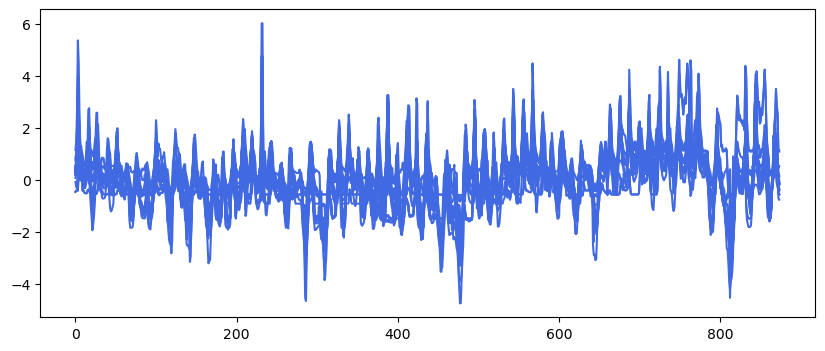

In [59]:
forecast_index = range(len(electricity_prices_test_scaled), len(electricity_prices_test_scaled) + 48)

# Compute quantiles for the forecast
low, median, high = np.quantile(forecast, [0.1, 0.5, 0.9], axis=0)

# Plot the results
plt.figure(figsize=(10, 4))
plt.plot(range(len(electricity_prices_test_scaled)), electricity_prices_test_scaled, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Electricity Prices')
plt.title('Electricity Prices Forecast')
plt.show()

# BasisFormer

In [1]:
seq_length = 96
pred_length = 48
label_length = 48
curr_model = "basis_former"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


NameError: name 'create_sequences' is not defined

In [ ]:
print("Sample training sequence x:", train_seq_x[0])
print("Sample training sequence y:", train_seq_y[0])
print("Sample training sequence x mark:", train_seq_x_mark[0])
print("Sample training sequence y mark:", train_seq_y_mark[0])

In [84]:
batch_size = 24

# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [87]:
# Check the dimensions
for batch in test_loader:
    batch_x, batch_y, batch_x_mark, batch_y_mark = batch
    print(f'Input batch shape: {batch_x.shape}')
    print(f'Output batch shape: {batch_y.shape}')
    print(f'Input mark shape: {batch_x_mark.shape}')
    print(f'Output mark shape: {batch_y_mark.shape}')
    break  # Just check the first batch

ValueError: too many values to unpack (expected 4)

Model utils abd definition

In [ ]:
####################################
# In PyTorch, all neural network models and layers are subclasses of torch.nn.Module.
# The <Module> class is the base class for all neural network modules,
# and it provides a blueprint for defining custom layers and models.

# The <forward> method defines the forward pass of the network,
# which is the process of passing input data through the layers of the network to compute the output.
# This is where the actual computation (such as matrix multiplication, activation functions, etc.) is defined.
####################################



#This class defines a two-layer MLP with a skip connection and ReLU activations.
#It reduces the input dimension, processes it, and then expands it back

class MLP(nn.Module):
    def __init__(self,input_len,output_len):
        super().__init__()
        self.linear1 = nn.Sequential(
            wn(nn.Linear(input_len, output_len)),
            nn.ReLU(),
            wn(nn.Linear(output_len,output_len))
        )

        self.linear2 = nn.Sequential(
            wn(nn.Linear(output_len, output_len)),
            nn.ReLU(),
            wn(nn.Linear(output_len, output_len))
        )

        self.skip = wn(nn.Linear(input_len, output_len))
        self.act = nn.ReLU()

    def forward(self,x):
        x = self.act(self.linear1(x)+self.skip(x))
        x = self.linear2(x)

        return x

class MLP_bottle(nn.Module):
    def __init__(self,input_len,output_len,bottleneck,bias=True):
        super().__init__()
        self.linear1 = nn.Sequential(
            wn(nn.Linear(input_len, bottleneck,bias=bias)),
            nn.ReLU(),
            wn(nn.Linear(bottleneck,bottleneck,bias=bias))
        )

        self.linear2 = nn.Sequential(
            wn(nn.Linear(bottleneck, bottleneck)),
            nn.ReLU(),
            wn(nn.Linear(bottleneck, output_len))
        )

        self.skip = wn(nn.Linear(input_len, bottleneck,bias=bias))
        self.act = nn.ReLU()

    def forward(self,x):
        x = self.act(self.linear1(x)+self.skip(x))
        x = self.linear2(x)

        return x



#This layer calculates the attention scores between queries, keys, and values using multi-head attention.
#This class implements multi-head attention using linear projections and softmax to compute attention score
#It is essential for capturing dependencies between different parts of the input sequence.

class channel_AutoCorrelationLayer(nn.Module):
    def __init__(self,d_model,n_heads, mask=False,d_keys=None,
                 d_values=None,dropout=0):
        super().__init__()

        self.mask = mask

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.query_projection = wn(nn.Linear(d_model,d_keys * n_heads))
        self.key_projection = wn(nn.Linear(d_model, d_keys * n_heads))
        self.value_projection = wn(nn.Linear(d_model, d_values * n_heads))
        self.out_projection = wn(nn.Linear(d_values * n_heads, d_model))
        self.n_heads = n_heads
        self.scale = d_keys ** -0.5
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values):
        num = len(queries.shape)
        if num == 2:
            L, _ = queries.shape
            S, _ = keys.shape
            H = self.n_heads

            queries = self.query_projection(queries).view(L, H, -1).permute(1,0,2)
            keys = self.key_projection(keys).view(S, H, -1).permute(1,0,2)
            values = self.value_projection(values).view(S, H, -1).permute(1,0,2)
            # queries = queries.view(L, H, -1).permute(1,0,2)
            # keys = keys.view(S, H, -1).permute(1,0,2)
            # values = values.view(S, H, -1).permute(1,0,2)

            dots = torch.matmul(queries, keys.transpose(-1, -2)) * self.scale

            attn = self.attend(dots)
            attn = self.dropout(attn)

            out = torch.matmul(attn, values)    #(H,L,D)

            out = out.permute(1,0,2).reshape(L,-1)
        else:
            B,L, _ = queries.shape
            B,S, _ = keys.shape
            H = self.n_heads

            queries = self.query_projection(queries).view(B,L, H, -1).permute(0,2,1,3)
            keys = self.key_projection(keys).view(B,S, H, -1).permute(0,2,1,3)
            values = self.value_projection(values).view(B,S, H, -1).permute(0,2,1,3)

            dots = torch.matmul(queries, keys.transpose(-1, -2)) * self.scale

            attn = self.attend(dots)

            attn = self.dropout(attn)

            out = torch.matmul(attn, values)    #(H,L,D)

            out = out.permute(0,2,1,3).reshape(B,L,-1)

        return self.out_projection(out),attn



# BCAB combines attention mechanisms and feed-forward networks to process both the basis functions and the input time series
# BCAB applies cross-attention to both the basis functions and the time series,
# followed by feed-forward networks and normalization.

class BCAB(nn.Module):
    def __init__(self, d_model,heads=8,index=0,d_ff=None,
                     dropout=0.1, activation="relu"):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.cross_attention_basis = channel_AutoCorrelationLayer(d_model,heads,dropout=dropout)
        self.conv1_basis = wn(nn.Linear(d_model,d_ff))
        self.conv2_basis = wn(nn.Linear(d_ff,d_model))

        self.dropout_basis = nn.Dropout(dropout)
        self.activation_basis = F.relu if activation == "relu" else F.gelu

        self.cross_attention_ts = channel_AutoCorrelationLayer(d_model,heads,dropout=dropout)
        self.conv1_ts = wn(nn.Linear(d_model,d_ff))
        self.conv2_ts = wn(nn.Linear(d_ff,d_model))

        self.dropout_ts = nn.Dropout(dropout)
        self.activation_ts = F.relu if activation == "relu" else F.gelu
        self.layer_norm11 = nn.LayerNorm(d_model)
        self.layer_norm12 = nn.LayerNorm(d_model)
        self.layer_norm21 = nn.LayerNorm(d_model)
        self.layer_norm22 = nn.LayerNorm(d_model)

    def forward(self, basis,series):
        basis_raw = basis
        series_raw = series
        basis_add, basis_attn = self.cross_attention_basis(
            basis_raw, series_raw, series_raw,
        )
        basis_out = basis_raw + self.dropout_basis(basis_add)
        basis_out = self.layer_norm11(basis_out)

        y_basis = basis_out
        y_basis = self.dropout_basis(self.activation_basis(self.conv1_basis(y_basis)))
        y_basis = self.dropout_basis(self.conv2_basis(y_basis))
        basis_out = basis_out + y_basis

        basis_out = self.layer_norm12(basis_out)

        series_add,series_attn = self.cross_attention_ts(
            series_raw, basis_raw, basis_raw
        )
        series_out = series_raw + self.dropout_ts(series_add)

        series_out = self.layer_norm21(series_out)

        y_ts = series_out
        y_ts = self.dropout_ts(self.activation_ts(self.conv1_ts(y_ts)))
        y_ts = self.dropout_ts(self.conv2_ts(y_ts))
        series_out = series_out + y_ts
        # series_out = series_raw

        series_out = self.layer_norm22(series_out)

        return basis_out, series_out, basis_attn, series_attn




#The Coefnet applies multiple BCABs to process the input and extract coefficients
#that represent the importance of different basis functions.
#This class defines a network of BCABs and a final layer to compute the coefficients
#representing the contribution of each basis function.


class Coefnet(nn.Module):
    def __init__(self, blocks,d_model,heads,norm_layer=None, projection=None):
        super().__init__()
        layers = [BCAB(d_model,heads) for i in range(blocks)]
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection
        # heads = heads if blocks > 0 else 1
        self.last_layer = last_layer(d_model,heads)

    def forward(self, basis, series):
        attns1 = []
        attns2 = []
        for layer in self.layers:
            basis,series,basis_attn,series_attn = layer(basis,series)   #basis(B,N,d)  series(B,C,d)
            attns1.append(basis_attn)
            attns2.append(series_attn)

        coef = self.last_layer(series,basis)  #(B,k,C,N)

        return coef,attns1,attns2





# The LastLayer computes the final attention scores between the processed series and the basis functions.

class last_layer(nn.Module):
    def __init__(self,d_model,n_heads, mask=False,d_keys=None,
                 d_values=None,dropout=0):
        super().__init__()
        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.query_projection = wn(nn.Linear(d_model,d_keys * n_heads))
        self.key_projection = wn(nn.Linear(d_model, d_keys * n_heads))
        self.n_heads = n_heads
        self.scale = d_keys ** -0.5

    def forward(self, queries, keys):
        B,L, _ = queries.shape
        B,S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B,L, H, -1).permute(0,2,1,3)
        keys = self.key_projection(keys).view(B,S, H, -1).permute(0,2,1,3)

        dots = torch.matmul(queries, keys.transpose(-1, -2)) * self.scale   #(B,H,L,S)

        return dots

In [ ]:

# The Basisformer model integrates all the components to perform time series forecasting.
#  It normalizes the input, generates basis functions, processes them through the coefficient network,
#  and combines the basis functions to produce the forecast output.
#  It also includes mechanisms for loss calculation during training,
#  using both smoothness and entropy losses to optimize the model.


class Basisformer(nn.Module):
    def __init__(self,seq_len,pred_len,d_model,heads,basis_nums,block_nums,bottleneck,map_bottleneck,device,tau):
        super().__init__()
        self.d_model = d_model # the dimensionality of the model's hidden state
        self.k = heads # number of attention heads
        self.N = basis_nums # number of basis functions
        self.coefnet = Coefnet(blocks=block_nums,d_model=d_model,heads=heads)

        self.pred_len = pred_len # prediction length
        self.seq_len = seq_len # sequence length

        # Multi-Layer Perceptron
        self.MLP_x = MLP_bottle(seq_len,heads * int(seq_len/heads),int(seq_len/bottleneck)) #processes the input sequence length to create a more compact representation
        self.MLP_y = MLP_bottle(pred_len,heads * int(pred_len/heads),int(pred_len/bottleneck)) #same for prediction
        self.MLP_sx = MLP_bottle(heads * int(seq_len/heads),seq_len,int(seq_len/bottleneck)) # re-expands the sequence length helping to restore some structure
        self.MLP_sy = MLP_bottle(heads * int(pred_len/heads),pred_len,int(pred_len/bottleneck)) # same for prediction


        # linear layers with weight normalization for projecting sequences into the model dimension
        # nn.Linear(seq_len, d_model) - fully connected linear layer that transforms the input from seq_len or pred_len dimensions to d_model dimensions
        # wn function applies weight normalization to the linear layer
        self.project1 = wn(nn.Linear(seq_len,d_model))
        self.project2 = wn(nn.Linear(seq_len,d_model))
        self.project3 = wn(nn.Linear(pred_len,d_model))
        self.project4 = wn(nn.Linear(pred_len,d_model))
        self.criterion1 = nn.MSELoss()
        self.criterion2 = nn.L1Loss(reduction='none')

        self.device = device # setting the device (CPU or GPU)

        # smooth array
        arr = torch.zeros((seq_len+pred_len-2,seq_len+pred_len))
        for i in range(seq_len+pred_len-2):
            arr[i,i]=-1
            arr[i,i+1] = 2
            arr[i,i+2] = -1
        self.smooth_arr = arr.to(device)

        # initializing basis function
        # MLP maps input to a higher dim space
        self.map_MLP = MLP_bottle(4, # input dim
                                  self.N*(self.seq_len+self.pred_len), #output dim
                                  map_bottleneck, # hidden layer size for the MLP
                                  bias=True)
        self.tau = tau # temperature parameter
        self.epsilon = 1E-5 # to avoid deletion by zero

    def forward(self,x,mark,y=None,train=True,y_mark=None):
        # normalization
        mean_x = x.mean(dim=1,keepdim=True)
        std_x = x.std(dim=1,keepdim=True)
        feature = (x - mean_x) / (std_x + self.epsilon)
        # reshaping
        B,L,C = feature.shape               # batch size, seq length, number of features
        feature = feature.permute(0,2,1)    # changing order of dimentions
        feature = self.project1(feature)    # (B,C,d)
                                            # linear transforrmation defined as wn(nn.Linear(seq_len, d_model))

        # creating basis function
        m = self.map_MLP(           # maps the input marker to a higher-dimensional space
           mark[:, 0].unsqueeze(1)  # selects the first marker and reshapes it for the MLP;
                                    # unsqueeze adds new dim at position in ()
                        ).reshape(B,self.seq_len + self.pred_len,self.N) #reshapes the output to have other dimensions


        # normalization
        m = m / torch.sqrt(torch.sum(m**2,dim=1,keepdim=True)+self.epsilon)

        # using basis functions in the model by splitting and projecting basis functions
        raw_m1 = m[:,:self.seq_len].permute(0,2,1)  #(B,L,N) # corresponding to the input sequence
        raw_m2 = m[:,self.seq_len:].permute(0,2,1)   #(B,L',N) #corresponding to the prediction sequence
        # permute(0,2,1) changes the order of dimensions for compatibility with other operations

        m1 = self.project2(raw_m1)    #(B,N,d) projects the input sequence basis functions into the model dimension

        # attention mechanism with basis functions
        score,attn_x1,attn_x2 = self.coefnet(m1,feature)    #(B,k,C,N)
        # applies the coefficient network to the projected basis functions and the features extracted from the input sequence
        # scores represent how much each basis function contributes to the final representation


        # combining basis functions
        base = self.MLP_y(raw_m2).reshape(B,self.N,self.k,-1).permute(0,2,1,3)   #(B,k,N,L/k)
        out = torch.matmul(score,base).permute(0,2,1,3).reshape(B,C,-1)  #(B,C,k * (L/k))
        out = self.MLP_sy(out).reshape(B,C,-1).permute(0,2,1)   #（BC,L）



        # reverse normalization
        output = out * (std_x + self.epsilon) + mean_x

        #loss calculation
        if train:
            l_smooth = torch.einsum('xl,bln->xbn',self.smooth_arr,m)
            l_smooth = abs(l_smooth).mean()
            # l_smooth = self.criterion1(l_smooth,torch.zeros_like(l_smooth))

            # #back
            mean_y = y.mean(dim=1,keepdim=True)
            std_y = y.std(dim=1,keepdim=True)
            feature_y_raw = (y - mean_y) / (std_y + self.epsilon)

            feature_y = feature_y_raw.permute(0,2,1)
            feature_y = self.project3(feature_y)   #(BC,d)
            m2 = self.project4(raw_m2)    #(N,d)

            score_y,attn_y1,attn_y2 = self.coefnet(m2,feature_y)    #(B,k,C,N)
            logit_q = score.permute(0,2,3,1) #(B,C,N,k)
            logit_k = score_y.permute(0,2,3,1) #(B,C,N,k)

            # l_pos = torch.bmm(logit_q.view(-1,1,self.k), logit_k.view(-1,self.k,1)).reshape(-1,1)  #(B*C*N,1,1)
            l_neg = torch.bmm(logit_q.reshape(-1,self.N,self.k), logit_k.reshape(-1,self.N,self.k).permute(0,2,1)).reshape(-1,self.N) # (B,C*N,N)

            labels = torch.arange(0,self.N,1,dtype=torch.long).unsqueeze(0).repeat(B*C,1).reshape(-1)

            labels = labels.to(self.device)

            cross_entropy_loss = nn.CrossEntropyLoss()
            l_entropy = cross_entropy_loss(l_neg/self.tau, labels)

            return output,l_entropy,l_smooth,attn_x1,attn_x2,attn_y1,attn_y2
        else:
            # #back
            mean_y = y.mean(dim=1,keepdim=True)
            std_y = y.std(dim=1,keepdim=True)
            feature_y_raw = (y - mean_y) / (std_y + self.epsilon)

            feature_y = feature_y_raw.permute(0,2,1)
            feature_y = self.project3(feature_y)   #(BC,d)
            m2 = self.project4(raw_m2)    #(N,d)

            score_y,attn_y1,attn_y2 = self.coefnet(m2,feature_y)    #(B,k,C,N)
            return output,m,attn_x1,attn_x2,attn_y1,attn_y2



In [ ]:
def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def metric(pred, true):
    mse = MSE(pred,true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)

    return mse, rmse, mape


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

def plot_seq_feature(pred_, true_, history_,label = "train",error = False,input='',wv=''):
    assert(pred_.shape == true_.shape)

    index = -1
    if pred_.shape[2]>800:
        index = 840
    pred = pred_.detach().clone()[..., index].unsqueeze(2)
    true = true_.detach().clone()[..., index].unsqueeze(2)
    history = history_.detach().clone()[..., index].unsqueeze(2)

    if len(pred.shape) == 3:  #BLD
        if error == False:
            pred = pred[0]
            true = true[0]
            history = history[0]
        else:
            largest_loss = 0
            largest_index = 0
            criterion = nn.MSELoss()
            for i in range(pred.shape[0]):
                loss = criterion(pred[i],true[i])
                if  loss > largest_loss:
                    largest_loss = loss
                    largest_index = i
            pred = pred[largest_index]
            true = true[largest_index]
            history = history[largest_index]
            input_error = input[largest_index]
            # wv_error = wv[largest_index]
            # print('input mean',input_error.mean())
            # print('input std',input_error.std())
            # print('out mean',true.mean())
            # print('out std',true.std())
            # print('wv mean',wv_error.mean())
            # print('wv std',wv_error.std())
            # print('end')

    pred = pred.cpu().numpy()
    true = true.cpu().numpy()
    history = history.cpu().numpy()

    L, D = pred.shape
    L_h,D_h = history.shape
    # if D == 1:
    #     pic_row, pic_col = 1, 1
    # else:
    #     pic_col = 2
    #     pic_row = math.ceil(D/pic_col)
    pic_row, pic_col = D, 1


    fig = plt.figure(figsize=(8*pic_row,8*pic_col))
    for i in range(1):
        ax = plt.subplot(pic_row,pic_col,i+1)
        ax.plot(np.arange(L_h), history[:, i], label = "history")
        ax.plot(np.arange(L_h,L_h+L), pred[:, i], label = "pred")
        ax.plot(np.arange(L_h,L_h+L), true[:, i], label = "true")
        ax.set_title("dimension = {},  ".format(i) + label)
        ax.legend()

    return fig


In [ ]:
pip install adabelief_pytorch==0.2.1

In [ ]:
# @title
from adabelief_pytorch import AdaBelief

def train(model, train_loader, test_loader, args, device, record_dir):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    log_and_print('[Info] Number of parameters: {}'.format(num_params))

    para1 = [param for name, param in model.named_parameters() if 'map_MLP' in name]
    para2 = [param for name, param in model.named_parameters() if 'map_MLP' not in name]

    # optimizer updates the model parameters during training
    optimizer = AdaBelief(
        [{'params': para1, 'lr': 5e-3}, {'params': para2, 'lr': args.learning_rate}],
        eps=1e-16, betas=(0.9, 0.999), weight_decouple=True, rectify=True
    )

    criterion = nn.MSELoss()

    # number of batches in the training set
    train_steps = len(train_loader)
    # initializing the TensorBoard writer for logging training process
    log_dir = os.path.join(record_dir, 'logs/fit')
    writer = SummaryWriter(log_dir)

    # defining for early stopping
    best_loss = float('inf')
    count = 0

    # training loop
    for epoch in range(args.train_epochs):
        # lists to store loss values
        train_loss = []
        loss_pred = []
        loss_of_ce = []
        l_s = []
        # setting model to training mode
        model.train()
        epoch_time = time.time()

        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, index) in enumerate(train_loader):
            # clears the gradients of all optimized tensors
            optimizer.zero_grad()

            # loading data to the specified device (originally to cuda)
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            # feature dimension
            f_dim = -1 if args.features == 'MS' else 0
            # matching the target sequence length required by the model
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)

            # forward pass through the model to get outputs and losses
            outputs, loss_infonce, loss_smooth, attn_x1, attn_x2, attn_y1, attn_y2 = model(batch_x, batch_x_mark, batch_y, True, batch_y_mark)

            # calculating loss
            loss_p = criterion(outputs, batch_y)
            lam1 = args.loss_weight_prediction
            lam2 = args.loss_weight_infonce
            lam3 = args.loss_weight_smooth

            # total loss
            loss = lam1 * loss_p + lam2 * loss_infonce + lam3 * loss_smooth
            train_loss.append(loss.item())
            loss_pred.append(loss_p.item())
            loss_of_ce.append(loss_infonce.item())
            l_s.append(loss_smooth.item())

            # gradient of the loss
            loss.backward()

            # updating model parameters
            optimizer.step()

            # logging every fifth step of the training process
            if (i + 1) % (train_steps // 5) == 0:
                log_and_print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))

        # every epoch logging
        log_and_print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
        # losses of every epoch
        train_loss = np.average(train_loss)
        loss1 = np.average(loss_pred)
        log_and_print('loss_pred:{0}'.format(loss1))
        loss2 = np.average(loss_of_ce)
        log_and_print('loss entropy:{0}'.format(loss2))
        loss3 = np.average(l_s)
        log_and_print('loss smooth:{0}'.format(loss3))

        # figures to TensorBoard
        fig = plot_seq_feature(outputs, batch_y, batch_x)
        writer.add_figure("figure_train", fig, global_step=epoch)
        writer.add_scalar('train_loss', train_loss, global_step=epoch)

        # saving model checkpoints
        ckpt_path = os.path.join(record_dir, args.check_point)
        if not os.path.exists(ckpt_path):
            os.makedirs(ckpt_path)
        # saving in new folder if it is first epoch
        if best_loss == float('inf'):
            best_loss = train_loss
            torch.save(model.state_dict(), os.path.join(ckpt_path, 'valid_best_checkpoint.pth'))
        else:
            if train_loss < best_loss:  # updates the results if training loss improves
                torch.save(model.state_dict(), os.path.join(ckpt_path, 'valid_best_checkpoint.pth'))
                best_loss = train_loss
                count = 0
            else:
                count += 1
        # final save at the end of each epoch
        torch.save(model.state_dict(), os.path.join(ckpt_path, 'final_checkpoint.pth'))
        # stopping training if loss doesn't improve for a number of epochs
        if count >= args.patience:
            break
    writer.close()
    return

In [ ]:
def train(model, train_loader, test_loader, args, device, record_dir):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    log_and_print('[Info] Number of parameters: {}'.format(num_params))

    para1 = [param for name, param in model.named_parameters() if 'map_MLP' in name]
    para2 = [param for name, param in model.named_parameters() if 'map_MLP' not in name]

    optimizer = AdaBelief([{'params': para1, 'lr': 5e-3}, {'params': para2, 'lr': args.learning_rate}], eps=1e-16, betas=(0.9, 0.999), weight_decouple=True, rectify=True)

    criterion = nn.MSELoss()

    train_steps = len(train_loader)
    log_dir = os.path.join(record_dir, 'logs/fit')
    writer = SummaryWriter(log_dir)

    best_loss = float('inf')
    count = 0

    for epoch in range(args.train_epochs):
        train_loss = []
        loss_pred = []
        loss_of_ce = []
        l_s = []
        model.train()
        epoch_time = time.time()

        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, index) in enumerate(train_loader):
            optimizer.zero_grad()

            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)

            try:
                outputs, loss_infonce, loss_smooth, attn_x1, attn_x2, attn_y1, attn_y2 = model(batch_x, batch_x_mark, batch_y, True, batch_y_mark)
            except Exception as e:
                print(f"Error in model forward pass: {e}")
                print(f"batch_x shape: {batch_x.shape}")
                print(f"batch_x_mark shape: {batch_x_mark.shape}")
                print(f"batch_y shape: {batch_y.shape}")
                print(f"batch_y_mark shape: {batch_y_mark.shape}")
                raise

            loss_p = criterion(outputs, batch_y)
            lam1 = args.loss_weight_prediction
            lam2 = args.loss_weight_infonce
            lam3 = args.loss_weight_smooth

            loss = lam1 * loss_p + lam2 * loss_infonce + lam3 * loss_smooth
            train_loss.append(loss.item())
            loss_pred.append(loss_p.item())
            loss_of_ce.append(loss_infonce.item())
            l_s.append(loss_smooth.item())

            loss.backward()
            optimizer.step()

            if (i + 1) % (train_steps // 5) == 0:
                log_and_print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))

        log_and_print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
        train_loss = np.average(train_loss)
        loss1 = np.average(loss_pred)
        log_and_print('loss_pred:{0}'.format(loss1))
        loss2 = np.average(loss_of_ce)
        log_and_print('loss entropy:{0}'.format(loss2))
        loss3 = np.average(l_s)
        log_and_print('loss smooth:{0}'.format(loss3))

        fig = plot_seq_feature(outputs, batch_y, batch_x)
        writer.add_figure("figure_train", fig, global_step=epoch)
        writer.add_scalar('train_loss', train_loss, global_step=epoch)

        ckpt_path = os.path.join(record_dir, args.check_point)
        if not os.path.exists(ckpt_path):
            os.makedirs(ckpt_path)
        if best_loss == float('inf'):
            best_loss = train_loss
            torch.save(model.state_dict(), os.path.join(ckpt_path, 'valid_best_checkpoint.pth'))
        else:
            if train_loss < best_loss:
                torch.save(model.state_dict(), os.path.join(ckpt_path, 'valid_best_checkpoint.pth'))
                best_loss = train_loss
                count = 0
            else:
                count += 1
        torch.save(model.state_dict(), os.path.join(ckpt_path, 'final_checkpoint.pth'))
        if count >= args.patience:
            break
    writer.close()
    return


In [ ]:
def log_and_print(text):
    logging.info(text)
    print(text)
    return

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Time series prediction - Basisformer')
    parser.add_argument('--is_training', type=bool, default=True, help='train or test')
    parser.add_argument('--device', type=int, default=0, help='gpu device')

    # data loader parameters
    parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
    parser.add_argument('--root_path', type=str, default='data', help='root path of the data file')
    parser.add_argument('--data_path', type=str, default='all_countries.csv', help='data file')
    parser.add_argument('--features', type=str, default='M', help='forecasting task')
    parser.add_argument('--freq', type=str, default='h', help='freq for time features encoding')

    # forecasting task parameters
    parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
    parser.add_argument('--pred_len', type=int, default=48, help='prediction sequence length')

    # model parameters
    parser.add_argument('--heads', type=int, default=16, help='head in attention')
    parser.add_argument('--d_model', type=int, default=100, help='dimension of model')
    parser.add_argument('--N', type=int, default=10, help='number of learnable basis')
    parser.add_argument('--block_nums', type=int, default=2, help='number of blocks')
    parser.add_argument('--bottleneck', type=int, default=2, help='reduction of bottleneck')
    parser.add_argument('--map_bottleneck', type=int, default=20, help='reduction of mapping bottleneck')

    # optimization parameters
    parser.add_argument('--train_epochs', type=int, default=1, help='train epochs')
    parser.add_argument('--batch_size', type=int, default=24 , help='batch size of train input data')
    parser.add_argument('--learning_rate', type=float, default=5e-4, help='optimizer learning rate')
    parser.add_argument('--tau', type=float, default=0.07, help='temperature of infonce loss')
    parser.add_argument('--loss_weight_prediction', type=float, default=1.0, help='weight of prediction loss')
    parser.add_argument('--loss_weight_infonce', type=float, default=1.0, help='weight of infonce loss')
    parser.add_argument('--loss_weight_smooth', type=float, default=1.0, help='weight of smooth loss')

    # checkpoint path
    parser.add_argument('--check_point', type=str, default='checkpoint', help='check point path, relative path')

    # add patience parameter
    parser.add_argument('--patience', type=int, default=5, help='early stopping patience')

    args, unknown = parser.parse_known_args()

    record_dir = os.path.join('records', args.data_path.split('.')[0], 'features_' + args.features,
                              'seq_len' + str(args.seq_len) + ',' + 'pred_len' + str(args.pred_len))
    if not os.path.exists(record_dir):
       os.makedirs(record_dir)

    if args.is_training:
        logger_file = os.path.join(record_dir, 'train.log')
    else:
        logger_file = os.path.join(record_dir, 'test.log')

    if os.path.exists(logger_file):
        with open(logger_file, "w") as file:
            file.truncate(0)
    logging.basicConfig(filename=logger_file, level=logging.INFO)

    log_and_print('Args in experiment:')
    log_and_print(args)

    device = torch.device(f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu')
    model = Basisformer(args.seq_len, args.pred_len, args.d_model, args.heads, args.N, args.block_nums, args.bottleneck, args.map_bottleneck, device, args.tau)

    log_and_print(model)
    model.to(device)


In [ ]:
args.train_epochs = 1
train(model, train_loader, test_loader, args, device, record_dir)

In [ ]:
#!tensorboard --logdir=event

In [ ]:
def metric(pred, true):
    mae = np.mean(np.abs(pred - true))
    mse = np.mean((pred - true) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((pred - true) / true)) * 100
    mspe = np.mean(((pred - true) / true) ** 2) * 100
    return mae, mse, rmse, mape, mspe

def test(model, test_loader, record_dir, args, device, scaler, country_names, test=True):
    if test:
        log_and_print('loading model')
        model.load_state_dict(torch.load(os.path.join(record_dir, args.check_point, 'valid_best_checkpoint.pth')))

    preds = []
    trues = []

    model.eval()
    t1 = time.time()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, index) in enumerate(test_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)

            outputs, m, attn_x1, attn_x2, attn_y1, attn_y2 = model(batch_x, batch_x_mark, batch_y, train=False, y_mark=batch_y_mark)

            outputs = outputs.detach().cpu().numpy()
            batch_y = batch_y.detach().cpu().numpy()

            outputs_rescaled = scaler.inverse_transform(outputs.reshape(-1, outputs.shape[-1])).reshape(outputs.shape)
            batch_y_rescaled = scaler.inverse_transform(batch_y.reshape(-1, batch_y.shape[-1])).reshape(batch_y.shape)

            preds.append(outputs_rescaled)
            trues.append(batch_y_rescaled)

    t2 = time.time()
    log_and_print('total_time:{0}'.format(t2 - t1))
    log_and_print('avg_time:{0}'.format((t2 - t1) / len(test_loader.dataset)))

    # Flatten lists
    preds = [item for sublist in preds for item in sublist]
    trues = [item for sublist in trues for item in sublist]

    preds = np.array(preds)
    trues = np.array(trues)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])

    # Save the results to a file
    np.savez(os.path.join(record_dir, 'test_results.npz'), preds=preds, trues=trues, country_names=country_names)

    mae, mse, rmse, mape, mspe = metric(preds, trues)
    log_and_print('mse:{}, mae:{}'.format(mse, mae))
    return mae, mse, rmse, mape, mspe


# Run the test function
test(model, test_loader, record_dir, args, device, scaler, country_names)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_predictions(true, pred, country_names, num_samples=24, samples_per_figure=6):
    num_figures = num_samples // samples_per_figure
    if num_samples % samples_per_figure:
        num_figures += 1
    
    for fig_num in range(num_figures):
        plt.figure(figsize=(20, 12))
        start_idx = fig_num * samples_per_figure
        end_idx = min((fig_num + 1) * samples_per_figure, num_samples)
        
        for i in range(start_idx, end_idx):
            plt.subplot(samples_per_figure // 2, 2, (i % samples_per_figure) + 1)
            plt.plot(true[i], label='True')
            plt.plot(pred[i], label='Pred')
            plt.legend()
            plt.title(f'{country_names[i]}')
        
        plt.tight_layout()
        plt.show()

# Load the results from the file
def load_and_plot_results(record_dir, num_samples=24, samples_per_figure=6):
    data = np.load(os.path.join(record_dir, 'test_results.npz'))
    preds = data['preds']
    trues = data['trues']
    country_names = data['country_names']
    plot_predictions(trues, preds, country_names, num_samples, samples_per_figure)

# Adjust plot parameters as needed and plot the results
load_and_plot_results(record_dir, num_samples=24, samples_per_figure=6)


# Sythetic Data Simulation

## Chronos Simulation

In [8]:
!pip install "chronos[training] @ git+https://github.com/amazon-science/chronos-forecasting.git"

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/y8/hhkwp1r54qg4ztcfjzk9c2800000gn/T/pip-install-g4pbpx20/chronos_a9273c93d1c0490cba1cbe7d30f0bc87
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/y8/hhkwp1r54qg4ztcfjzk9c2800000gn/T/pip-install-g4pbpx20/chronos_a9273c93d1c0490cba1cbe7d30f0bc87
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit afd9cfd062b60ca1ba8d7c9daef7dc820489db0a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.1 MB/s eta 0:00:00
  Using cached gluonts-0.15.1-py3-none-any.whl.metadata (9.9 kB)
  Using cached typer-0.12.3-py3-none-any.whl.metadata (15 kB)
  Using cached typer_config-1.4.0-py3-none-any.whl.metadata (4.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [2]:
!python supporting_files_chronos/kernel-synth.py --num-series 500 --max-kernels 2

100%|█████████████████████████████████████████| 500/500 [01:36<00:00,  5.20it/s]


In [3]:
import pyarrow.ipc as ipc

file_path = 'supporting_files_chronos/kernelsynth-data.arrow'

with open(file_path, 'rb') as f:
    reader = ipc.RecordBatchFileReader(f)
    table = reader.read_all()

df_ch = table.to_pandas()

print(df_ch)

         start                                             target
0   2000-01-01  [0.3690353276138971, 0.44386602613121034, 0.51...
1   2000-01-01  [0.033015551690038884, -0.23397444961837965, -...
2   2000-01-01  [-1.476937197412458, -1.5676278563239772, -1.6...
3   2000-01-01  [-0.16003612245875626, -0.25223661756945526, -...
4   2000-01-01  [-1.3052362051778974, -1.3020472216001648, -1....
..         ...                                                ...
495 2000-01-01  [-1.8427913502113633, -1.8660240145350093, -1....
496 2000-01-01  [-2.2573159760801476, -2.13936135673169, -2.01...
497 2000-01-01  [-1.3484827032112752, -0.9293215555886851, -0....
498 2000-01-01  [0.25171543882670483, 0.21204651463371202, 0.1...
499 2000-01-01  [0.41956252542817685, 0.42232395863695993, 0.4...

[500 rows x 2 columns]


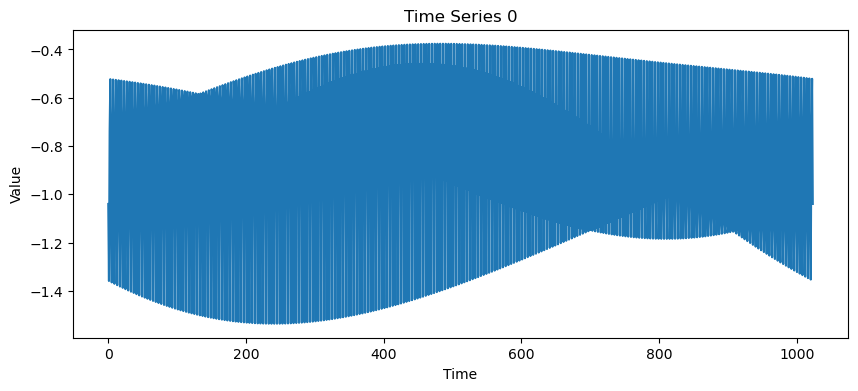

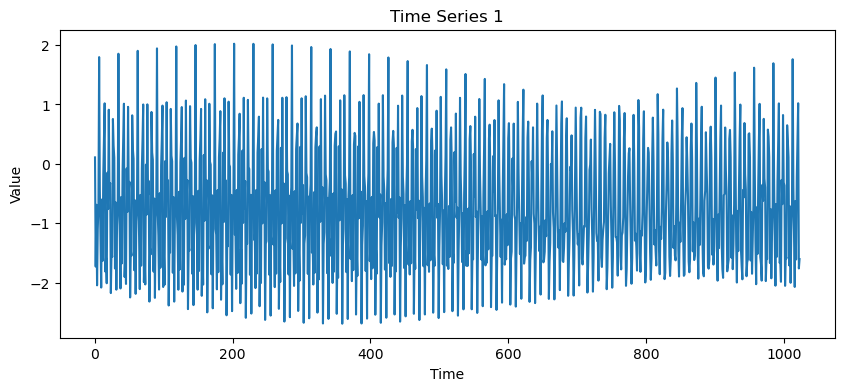

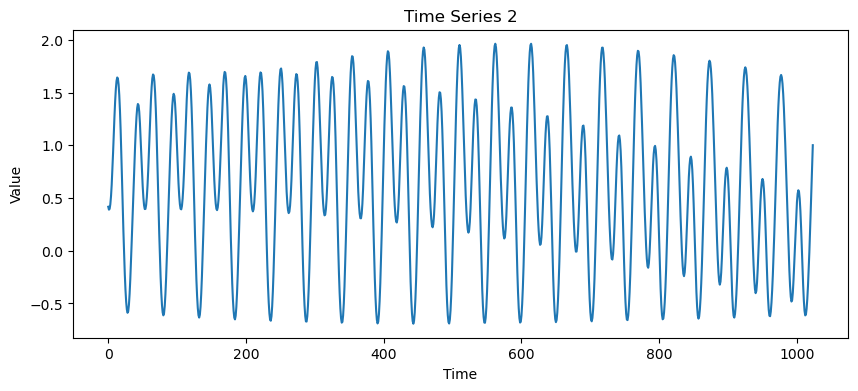

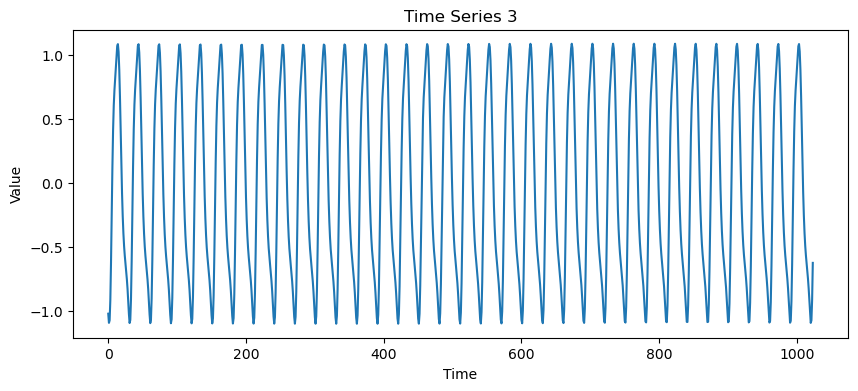

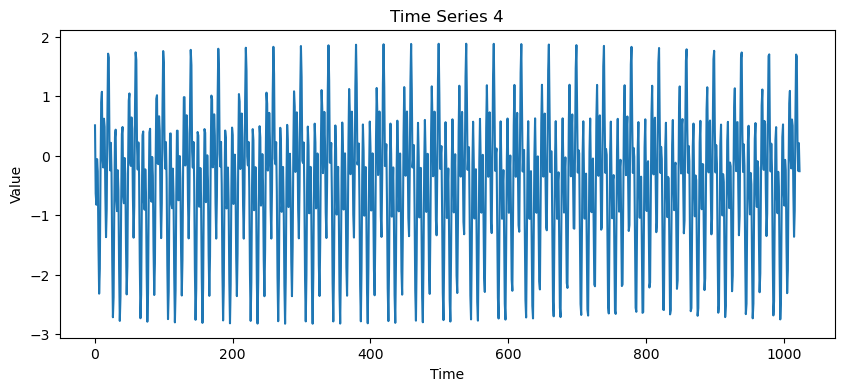

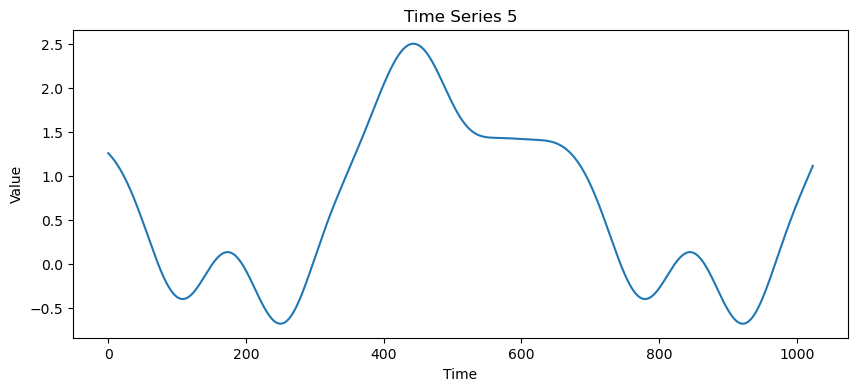

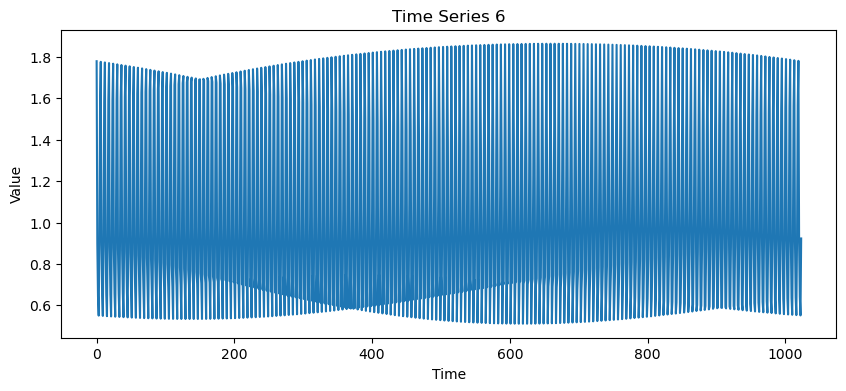

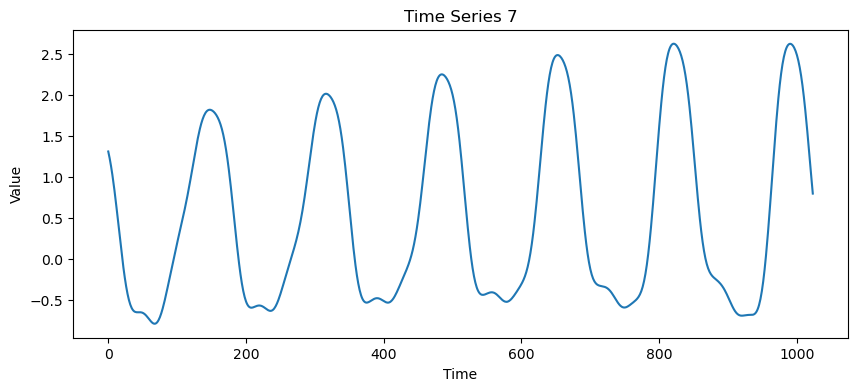

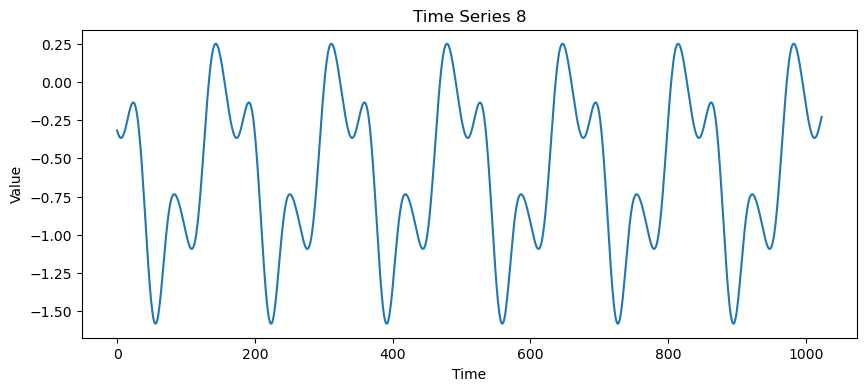

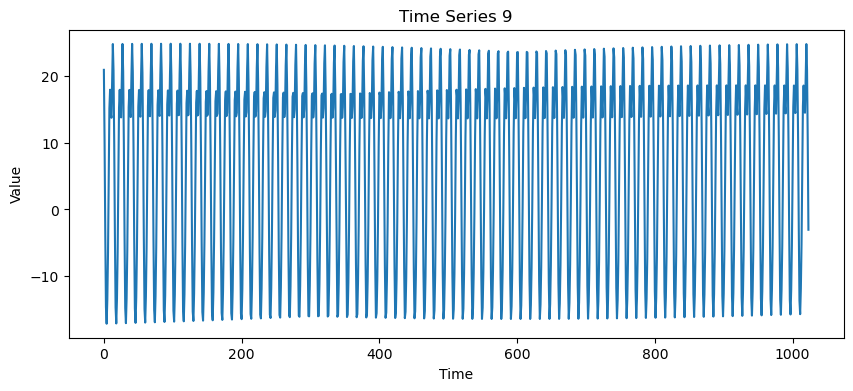

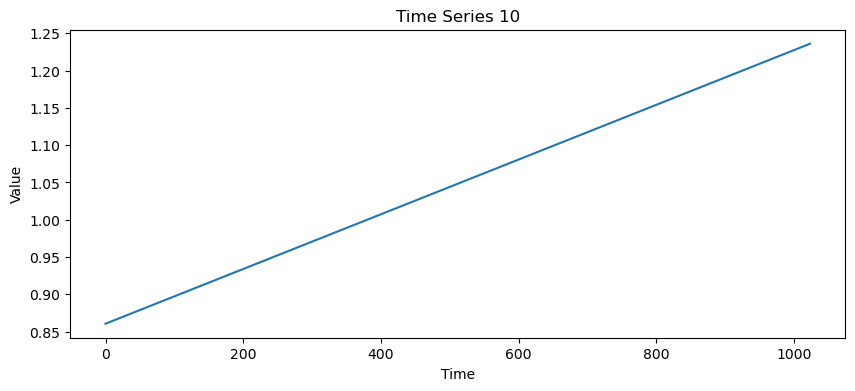

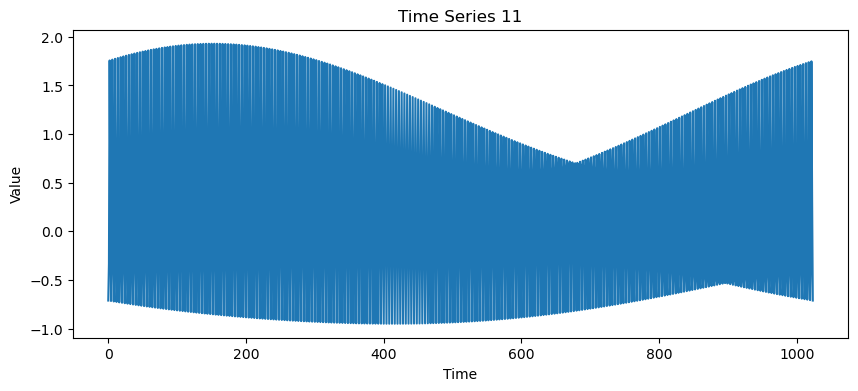

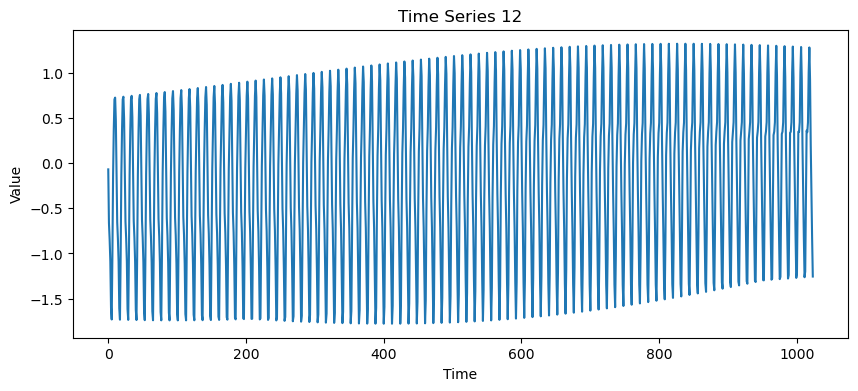

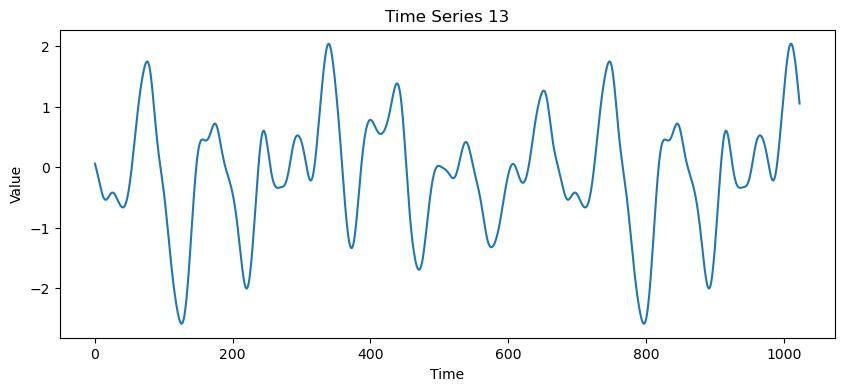

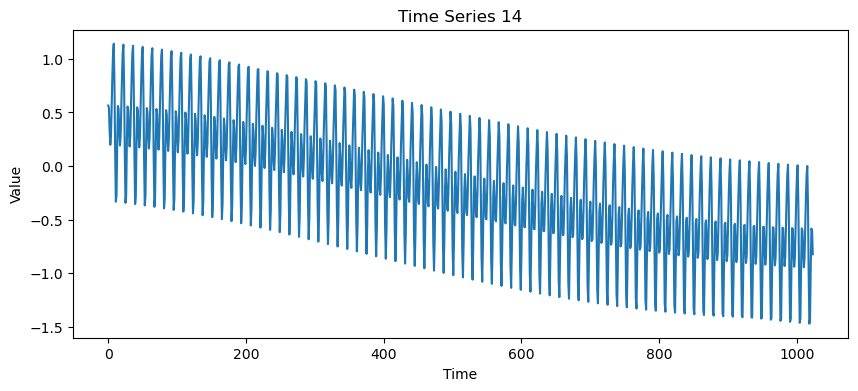

In [13]:
import matplotlib.pyplot as plt 

for i in range(15):
    plt.figure(figsize=(10, 4))
    plt.plot(df_ch['target'].iloc[i])
    plt.title(f'Time Series {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

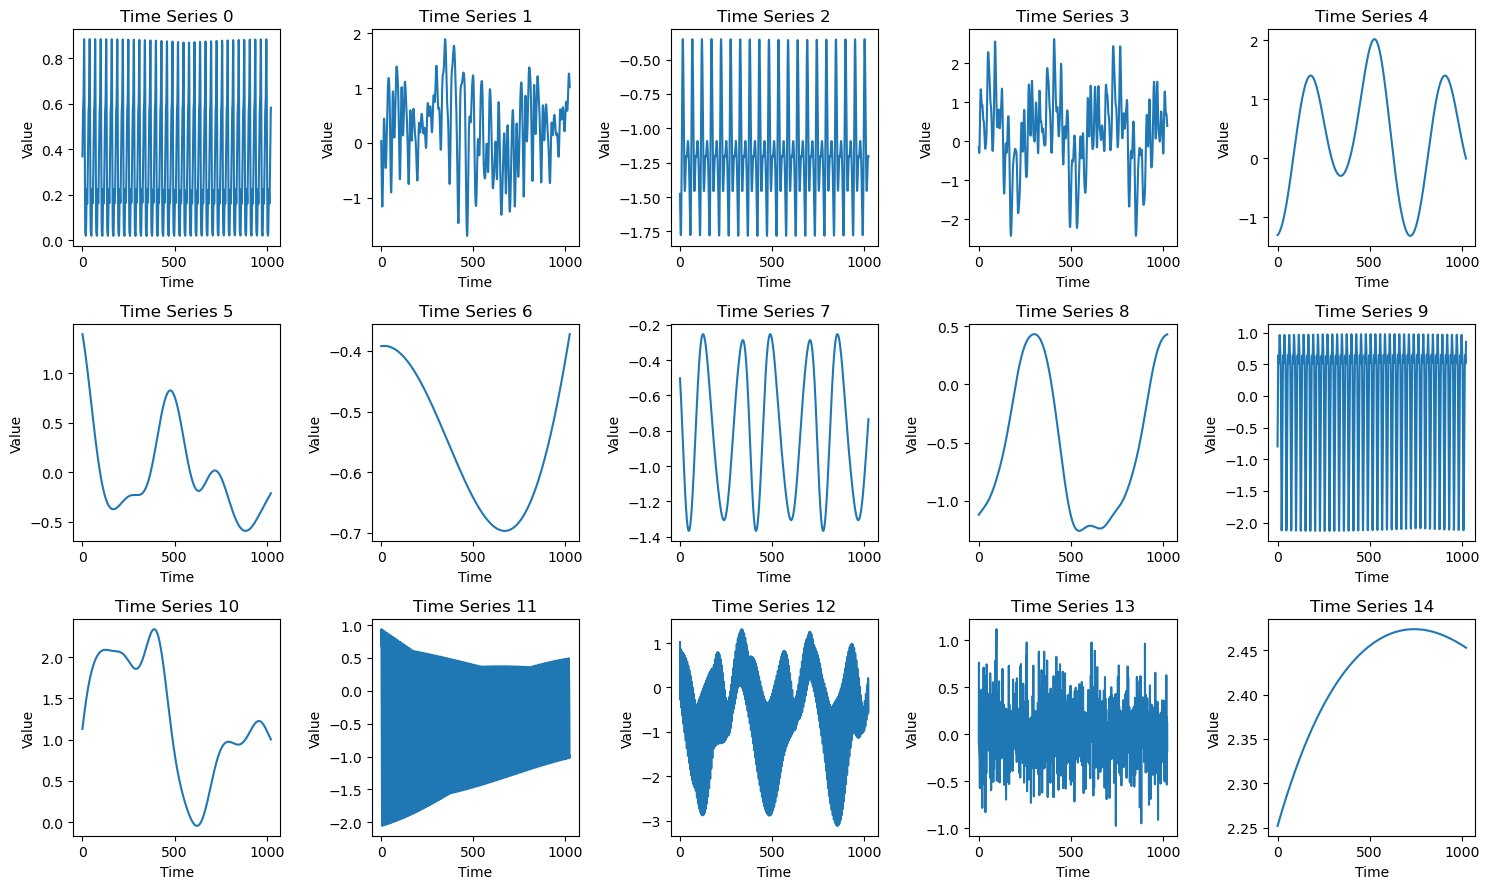

In [6]:
import matplotlib.pyplot as plt 

# Number of time series
num_series = 15
# Number of plots per row
plots_per_row = 5
# Number of rows
num_rows = (num_series + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 3))

for i in range(num_series):
    row = i // plots_per_row
    col = i % plots_per_row
    ax = axes[row, col]
    ax.plot(df_ch['target'].iloc[i])
    ax.set_title(f'Time Series {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

# Remove any empty subplots
for j in range(i + 1, num_rows * plots_per_row):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

## DYNOTEARS Causal Structure

In [22]:
from causalnex.structure.notears import from_pandas
df_str = df.drop(columns=['Datetime (UTC)'])
sm = from_pandas(df_str)

In [28]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("supporting_files_dynotears/01_fully_connected.html")

01_fully_connected.html


In [29]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("supporting_files_dynotears/01_thresholded.html")

supporting_files_dynotears/01_thresholded.html
